# Amazon Customer Review Analysis
## By. Andrew Simmons & Jingnan Jin

In [1]:
from collections import defaultdict
from functools import reduce
from operator import itemgetter
from pathlib import Path
import re

import findspark
import matplotlib.pyplot as plt
import numpy as np

findspark.init()

# create entry points to spark
try:
    sc.stop()
except:
    pass
from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession
conf = SparkConf().setAppName("AmazonCustomerReviewAnalysis").setMaster("local[*]")
sc = SparkContext(conf=conf)
spark = SparkSession(sparkContext=sc)

In [2]:
# Constants
PLOT_DIMENSIONS = (20, 10)

In [3]:
"""Process list of files to separate by category"""

data_dir = Path('sample_data')
data_files = data_dir.glob('*.tsv.gz')

data_categories = defaultdict(list)
for file in data_files:
    category_name = file.name[18:-13].replace('_', ' ')
    data_categories[category_name].append(file)

In [4]:
"""Create mapping of category names to unioned RDD"""

for key, value in data_categories.items():
    data_categories[key] = sc.union([sc.textFile(str(file)) for file in value])

In [5]:
"""Remove headers from data"""

for key, value in data_categories.items():
    data_categories[key] = value.filter(lambda x: not x.startswith('marketplace'))

In [6]:
"""Split TSV"""

for key, value in data_categories.items():
    data_categories[key] = value.map(lambda x: x.split('\t'))

## How many records exist in each category?

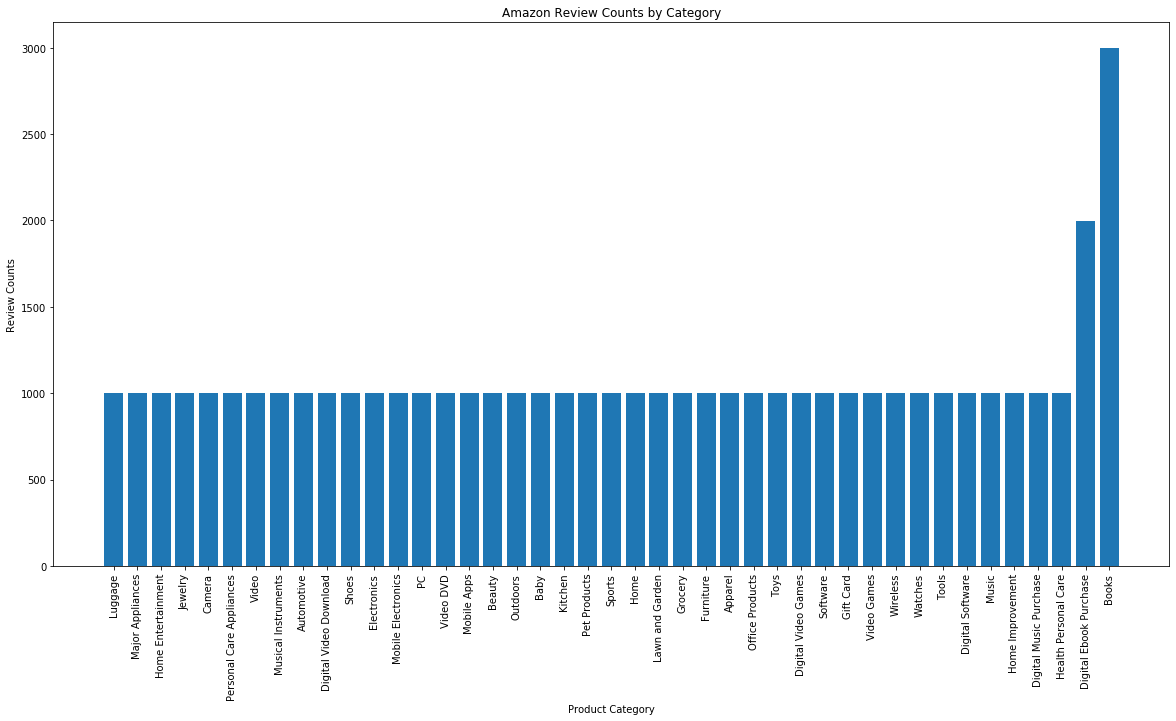

In [7]:
record_counts = []
for key, value in data_categories.items():
    record_counts.append((key, value.count()))

categories, counts = zip(*sorted(record_counts, key=itemgetter(1)))

fig, ax = plt.subplots()
fig.set_size_inches(PLOT_DIMENSIONS)

rects = ax.bar(categories, counts)

ax.set_title('Amazon Review Counts by Category')
ax.set_xlabel('Product Category')
ax.set_ylabel('Review Counts')

for tick in ax.get_xticklabels():
    tick.set_rotation(90)

In [11]:
print(f'Total number of reviews in dataset: {sum(counts)}')

Total number of reviews in dataset: 45954
